In [1]:
# standard Python packages for scientific computing:
import numpy as np  # Numerical Python
import matplotlib.pyplot as plt  # plotting
import math as m
import os  # operating system / file utilities
import sys
from timestep import *

    
# from numba import jit
# first did "conda install numba".  See
# https://numba.readthedocs.io/en/stable/user/5minguide.html

In [2]:
# default figure size okay if notebook is zoomed for class presentation:
# plt.rcParams["figure.figsize"] = [6.4, 4.8] # default
plt.rcParams["figure.figsize"] = [8.0, 6.0]

In [3]:
# create a subdirectory to hold figures
# (if it doesn't exist already)
os.makedirs("../figs", exist_ok=True)

## Simple advection problem

In [4]:
def init_smooth(N):
    # created the grid
    x = np.linspace(0, 1, N+1)
    x = (x[0:-1] + x[1:]) / 2
    u = np.zeros(np.size(x))
    
    # set initial conditions
    u = 1 * np.exp(- (x-0.5-1/1234567) ** 2 / 0.07 ** 2)
    
    return x, u

In [5]:
def init_step(N):
    # created the grid
    x = np.linspace(0, 1, N+1)
    x = (x[0:-1] + x[1:]) / 2
    u = np.zeros(np.size(x))
    
    # set initial conditions
    u = 1 * np.exp(- (x-0.3) ** 2 / 0.07 ** 2)
    where = np.where(np.abs(x-0.7) <= 0.1)[0]
    u[where] = 1

    return x, u

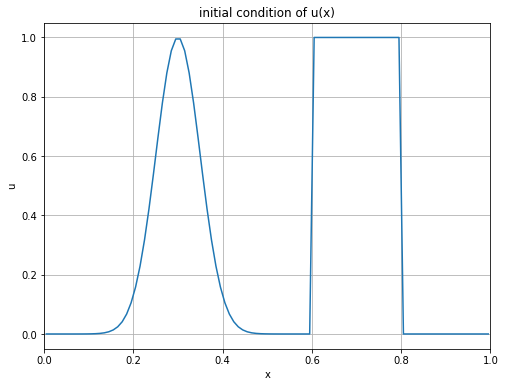

In [6]:
# creating grid
N = 100
x = np.linspace(0,1,N+1)
x = (x[0:-1] + x[1:]) / 2
u = np.zeros(np.size(x))

# set initial conditions
u = 1 * np.exp(- (x-0.3) ** 2 / 0.07 ** 2)
where = np.where(np.abs(x-0.7) <= 0.1)[0]
u[where] = 1

# plot
plt.plot(x,u)
plt.xlabel('x')
plt.ylabel('u')
plt.title('initial condition of u(x)')
plt.xlim(0,1)
plt.grid()
plt.show()

### Finite volume method
#### 2nd order centered differencing

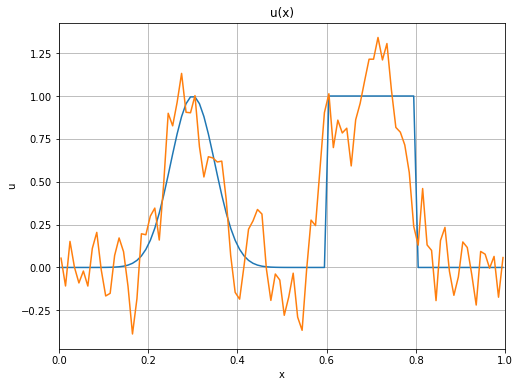

In [7]:
# advect
c = 1
dx = 1/N
dt = 0.01 * dx

N_steps = 1 / c / dt

u_next = u
for jj in range(int(N_steps)):
    # flux
    u_mod = np.insert(u_next, (0, N), (u_next[-1], u_next[0]), axis = 0)
    f = c * 0.5 * (u_mod[0:-1] + u_mod[1:])

    # update the system
    u_next = u_next - (dt / dx) * (f[1:] - f[0:-1])

# plot result
# plot
plt.plot(x,u)
plt.plot(x,u_next)
plt.xlabel('x')
plt.ylabel('u')
plt.title('u(x)')
plt.xlim(0,1)
plt.grid()
plt.show()

#### 1st-3rd order upwind differencing

In [14]:
# general function to advect
def advect(x, u, c, dt, n_steps, flux_method, step_method):
    for ii in range(n_steps):
        # march in time
        u = step_method(x, u, flux_method, c, dt)
        
    return u

### Test with Forward Euler scheme

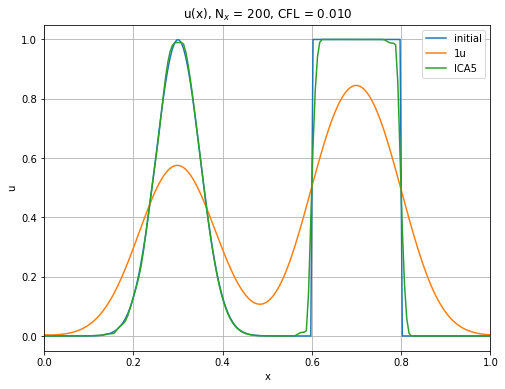

In [9]:
N = 200
x, u = init_step(N)

# advect
c = 1
dx = 1/N
dt = 0.01 * dx / c
N_steps = int(1 / c / dt)

u_1u = advect(x, u, c, dt, N_steps, first_order_upwind, forward_euler)
u_2u = advect(x, u, c, dt, N_steps, second_order_upwind, forward_euler)
u_2c = advect(x, u, c, dt, N_steps, second_order_centered, forward_euler)
u_3u = advect(x, u, c, dt, N_steps, third_order_upwind, forward_euler)
u_ICA5 = advect(x, u, c, dt, N_steps, ICA5, forward_euler)

# plot result
plt.plot(x,u,label='initial')
plt.plot(x,u_1u,label='1u')
#plt.plot(x,u_2u,label='2u')
#plt.plot(x,u_2c,label='2c')
#plt.plot(x,u_3u,label='3u-biased')
plt.plot(x,u_ICA5,label='ICA5')
plt.xlabel('x')
plt.ylabel('u')
plt.title('u(x), N$_x$ = %d, CFL = %.3f' % (N, c * dt / dx))
plt.xlim(0,1)
plt.grid()
plt.legend()
plt.show()

### Test with RK3 scheme

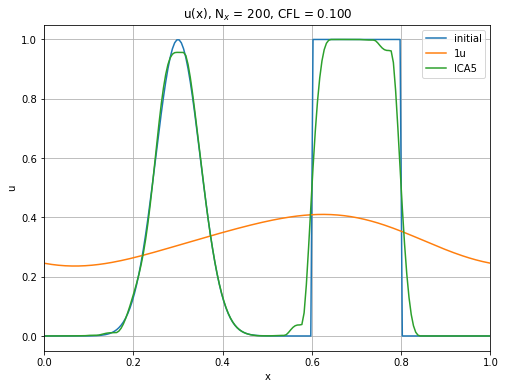

In [10]:
N = 200
x, u = init_step(N)

# advect
c = 1
dx = 1/N
dt = 0.1 * dx / c
N_steps = int(1 / c / dt * 10)

u_1u = advect(x, u, c, dt, N_steps, first_order_upwind, RK3)
u_2u = advect(x, u, c, dt, N_steps, second_order_upwind, RK3)
u_2c = advect(x, u, c, dt, N_steps, second_order_centered, RK3)
u_3u = advect(x, u, c, dt, N_steps, third_order_upwind, RK3)
u_ICA5 = advect(x, u, c, dt, N_steps, ICA5, RK3)

# plot result
plt.plot(x,u,label='initial')
plt.plot(x,u_1u,label='1u')
#plt.plot(x,u_2u,label='2u')
#plt.plot(x,u_2c,label='2c')
#plt.plot(x,u_3u,label='3u-biased')
plt.plot(x,u_ICA5,label='ICA5')
plt.xlabel('x')
plt.ylabel('u')
plt.title('u(x), N$_x$ = %d, CFL = %.3f' % (N, c * dt / dx))
plt.xlim(0,1)
plt.grid()
plt.legend()
plt.show()

In [11]:
print('\int u      dx = ', np.sum(u) * dx)
print('\int u_1u   dx = ', np.sum(u_1u) * dx)
print('\int u_2u   dx = ', np.sum(u_2u) * dx)
print('\int u_2c   dx = ', np.sum(u_2c) * dx)
print('\int u_3u   dx = ', np.sum(u_3u) * dx)
print('\int u_ICA5 dx = ', np.sum(u_ICA5) * dx)

\int u      dx =  0.32407176939812005
\int u_1u   dx =  0.32407176939772636
\int u_2u   dx =  0.3240717693977267
\int u_2c   dx =  0.3240717693977345
\int u_3u   dx =  0.3240717693977227
\int u_ICA5 dx =  0.3240717693977572


In [28]:
def convergence_error(flux_method, step_method, ngrids, error_type):
    errors = np.zeros(np.size(ngrids))
    for ii, N in enumerate(ngrids):
        x, u = init_step(N)
        c = 1
        dx = 1 / N
        # CFL = 0.01
        dt = 0.01 * dx / c
        N_steps = int(1 / c / dt)
        u_end = advect(x, u, c, dt, N_steps, flux_method, step_method)
        error = np.abs(u_end - u)
        if error_type == 'max error':
            errors[ii] = np.max(error)
        elif error_type == 'L2 error':
            errors[ii] = np.sqrt(np.sum(error ** 2) / N)
    return errors

In [29]:
ngrids = np.array([100,200,400,600,1000,2000,4000])
errors = convergence_error(third_order_upwind, forward_euler, ngrids, 'L2 error')

Text(0.5, 1.0, 'Convergence, 3u-biased, CFL=0.01')

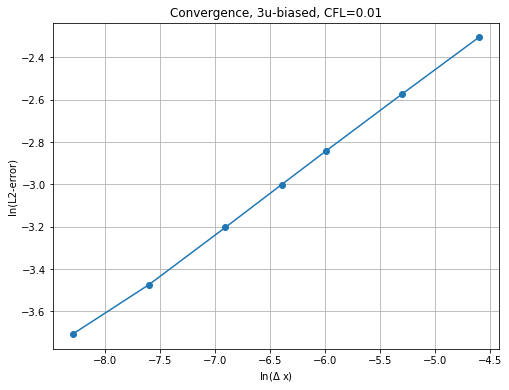

In [34]:
plt.plot(np.log(1/ngrids), np.log(errors), '-o')
plt.grid()
plt.xlabel('ln($\Delta$ x)')
plt.ylabel('ln(L2-error)')
plt.title('Convergence, 3u-biased, CFL=0.01')

#### Old code: 1st-order upwind

In [12]:
N = 100
x, u = init_step(N)

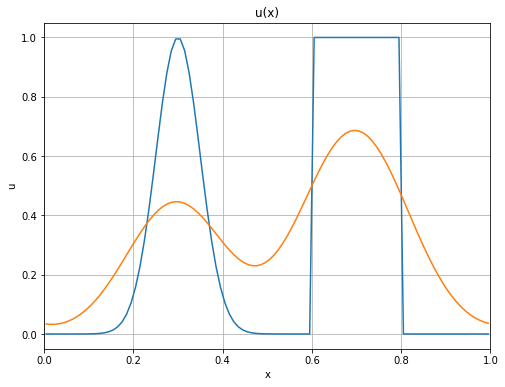

In [13]:
# advect
c = 1
dx = 1/N
dt = 0.01 * dx

N_steps = 1 / c / dt

u_next = u
for jj in range(1 * int(N_steps)):
    # flux
    u_mod = np.insert(u_next, 0, u_next[-1], axis = 0)
    f = c * u_mod

    # update the system
    u_next = u_next - (dt / dx) * (f[1:] - f[0:-1])

# plot result
# plot
plt.plot(x,u)
plt.plot(x,u_next)
plt.xlabel('x')
plt.ylabel('u')
plt.title('u(x)')
plt.xlim(0,1)
plt.grid()
plt.show()

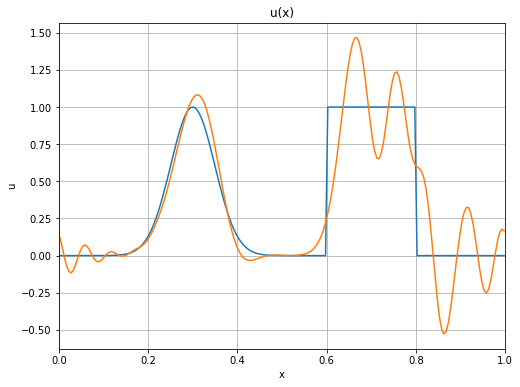

In [14]:
N = 200
x, u = init_step(N)

# advect
c = 1
dx = 1/N
dt = 0.1 * dx
N_steps = int(1 / c / dt)

u_next = u
for jj in range(int(N_steps)):
    # flux (at j+1/2)
    f = c * (u_next + 0.5 * (u_next - np.roll(u_next, 1)))

    # update the system
    u_next = u_next - (dt / dx) * (f - np.roll(f, 1))

# plot result
# plot
plt.plot(x,u)
plt.plot(x,u_next)
plt.xlabel('x')
plt.ylabel('u')
plt.title('u(x)')
plt.xlim(0,1)
plt.grid()
plt.show()

#### How np.roll( ) works

In [15]:
b = np.arange(0,10)
print('original array')
print('      ', b)
print('--------------------------------------')
for ii in range(-9,10):
    print('%2d' % ii, ' : ', np.roll(b, ii))

original array
       [0 1 2 3 4 5 6 7 8 9]
--------------------------------------
-9  :  [9 0 1 2 3 4 5 6 7 8]
-8  :  [8 9 0 1 2 3 4 5 6 7]
-7  :  [7 8 9 0 1 2 3 4 5 6]
-6  :  [6 7 8 9 0 1 2 3 4 5]
-5  :  [5 6 7 8 9 0 1 2 3 4]
-4  :  [4 5 6 7 8 9 0 1 2 3]
-3  :  [3 4 5 6 7 8 9 0 1 2]
-2  :  [2 3 4 5 6 7 8 9 0 1]
-1  :  [1 2 3 4 5 6 7 8 9 0]
 0  :  [0 1 2 3 4 5 6 7 8 9]
 1  :  [9 0 1 2 3 4 5 6 7 8]
 2  :  [8 9 0 1 2 3 4 5 6 7]
 3  :  [7 8 9 0 1 2 3 4 5 6]
 4  :  [6 7 8 9 0 1 2 3 4 5]
 5  :  [5 6 7 8 9 0 1 2 3 4]
 6  :  [4 5 6 7 8 9 0 1 2 3]
 7  :  [3 4 5 6 7 8 9 0 1 2]
 8  :  [2 3 4 5 6 7 8 9 0 1]
 9  :  [1 2 3 4 5 6 7 8 9 0]


## Shallow water wave propagation

### Initialization

In [333]:
g = 9.8
D_0 = 1
u_0 = 0
N = 100
x, eta = init_step(N)
h = np.ones(np.size(x)) * D_0
D = h + eta
u = np.ones(np.size(x)) * u_0
c = np.sqrt(g * D)

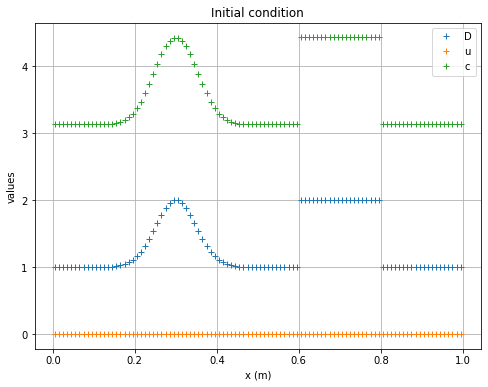

In [334]:
plt.plot(x, D, '+', label = 'D')
plt.plot(x, u, '+', label = 'u')
plt.plot(x, c, '+', label = 'c')
plt.grid()
plt.xlabel('x (m)')
plt.ylabel('values')
plt.legend()
plt.title('Initial condition')
plt.show()

### Construct the "advection" matrix

In [335]:
A = np.array([[0, 1], [-(u_0**2)+(g*D_0), 2*u_0]])
A

array([[0. , 1. ],
       [9.8, 0. ]])

### Finding eigenvalues and eigenvectors

In [336]:
w, v = np.linalg.eig(A)
w

array([ 3.13049517, -3.13049517])

In [337]:
v

array([[ 0.30429031, -0.30429031],
       [ 0.95257934,  0.95257934]])

### Construct new variables for simple advection problem

In [338]:
q = np.array([D - D_0, D*u - D_0*u_0])
q

array([[1.93571479e-08, 6.32272403e-08, 1.98262591e-07, 5.96830518e-07,
        1.72478498e-06, 4.78511739e-06, 1.27445330e-05, 3.25858422e-05,
        7.99848377e-05, 1.88477747e-04, 4.26369558e-04, 9.25946706e-04,
        1.93045414e-03, 3.86372920e-03, 7.42382226e-03, 1.36937422e-02,
        2.42488095e-02, 4.12223164e-02, 6.72741248e-02, 1.05399225e-01,
        1.58525988e-01, 2.28895481e-01, 3.17283627e-01, 4.22213192e-01,
        5.39373532e-01, 6.61486763e-01, 7.78800783e-01, 8.80248504e-01,
        9.55119928e-01, 9.94910952e-01, 9.94910952e-01, 9.55119928e-01,
        8.80248504e-01, 7.78800783e-01, 6.61486763e-01, 5.39373532e-01,
        4.22213192e-01, 3.17283627e-01, 2.28895481e-01, 1.58525988e-01,
        1.05399225e-01, 6.72741248e-02, 4.12223164e-02, 2.42488095e-02,
        1.36937422e-02, 7.42382226e-03, 3.86372920e-03, 1.93045414e-03,
        9.25946706e-04, 4.26369558e-04, 1.88477747e-04, 7.99848377e-05,
        3.25858422e-05, 1.27445330e-05, 4.78511739e-06, 1.724784

In [339]:
psi = np.linalg.solve(v, q)
psi

array([[ 3.18070396e-08,  1.03892957e-07,  3.25778679e-07,
         9.80692613e-07,  2.83411092e-06,  7.86275021e-06,
         2.09414046e-05,  5.35440024e-05,  1.31428500e-04,
         3.09700541e-04,  7.00596674e-04,  1.52148569e-03,
         3.17205983e-03,  6.34875491e-03,  1.21985848e-02,
         2.25011144e-02,  3.98448599e-02,  6.77351776e-02,
         1.10542667e-01,  1.73188599e-01,  2.60484779e-01,
         3.76113654e-01,  5.21350198e-01,  6.93767068e-01,
         8.86281151e-01,  1.08693366e+00,  1.27970027e+00,
         1.44639589e+00,  1.56942219e+00,  1.63480551e+00,
         1.63480551e+00,  1.56942219e+00,  1.44639589e+00,
         1.27970027e+00,  1.08693366e+00,  8.86281151e-01,
         6.93767068e-01,  5.21350198e-01,  3.76113654e-01,
         2.60484779e-01,  1.73188599e-01,  1.10542667e-01,
         6.77351776e-02,  3.98448599e-02,  2.25011144e-02,
         1.21985848e-02,  6.34875491e-03,  3.17205983e-03,
         1.52148569e-03,  7.00596674e-04,  3.09700541e-0

### Advection

In [340]:
psi_1 = psi[0,:]
psi_2 = psi[1,:]
c_1 = w[0]
c_2 = w[1]

In [341]:
CFL = 0.1
N_cycles = 0.14
dx = 1/N
dt = abs(CFL * dx / c_1)
N_steps = int(1 / abs(c_1) / dt * N_cycles)

psi_1_next = advect(x, psi_1, c_1, dt, N_steps, ICA5, RK3)

In [342]:
CFL = 0.1
N_cycles = 0.14
dx = 1/N
dt = abs(CFL * dx / c_2)
N_steps = int(1 / abs(c_2) / dt * N_cycles)

psi_2_next = advect(x, psi_2, c_2, dt, N_steps, ICA5, RK3)

### Convert back to physical values

In [343]:
psi_next = np.array([psi_1_next, psi_2_next])
q_next = np.matmul(v, psi_next) + np.array([[D_0], [D_0*u_0]])

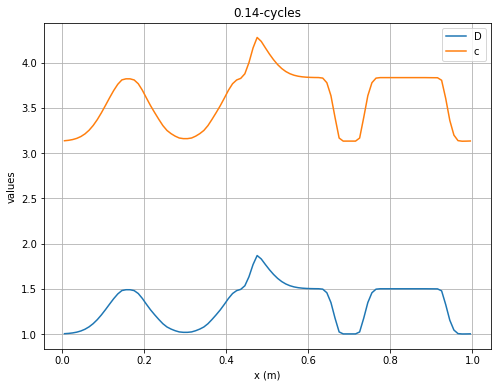

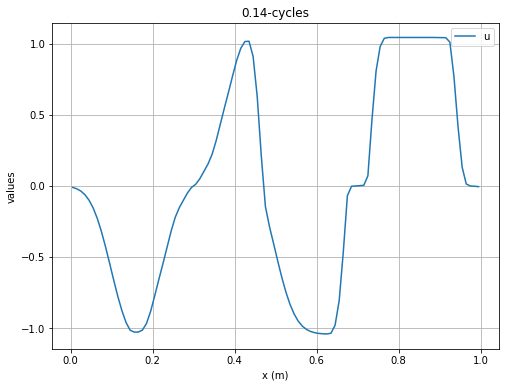

In [344]:
plt.plot(x, q_next[0,:], label = 'D')
plt.plot(x, np.sqrt(q_next[0,:] * g), label = 'c')
plt.grid()
plt.xlabel('x (m)')
plt.ylabel('values')
plt.legend()
plt.title('%.2f-cycles' % N_cycles)
plt.show()

plt.plot(x, q_next[1,:] / q_next[0,:], label = 'u')
plt.grid()
plt.xlabel('x (m)')
plt.ylabel('values')
plt.legend()
plt.title('%.2f-cycles' % N_cycles)
plt.show()

In [58]:
bb = np.array([[1, -1], [1, 0]])
bb

array([[ 1, -1],
       [ 1,  0]])

In [59]:
np.matmul(bb, aa)

array([[-4, -4, -4, -4],
       [ 1,  2,  3,  4]])

## Alternative construction with [D, u] instead of [D, Du]

### Initialization

In [160]:
g = 9.8
D_0 = 1
u_0 = 0
nu_0 = 1.5
N = 100
x, eta = init_step(N)
h = np.ones(np.size(x)) * D_0
D = h + eta
u = np.ones(np.size(x)) * u_0
nu = np.ones(np.size(x)) * nu_0
c = np.sqrt(g * D)

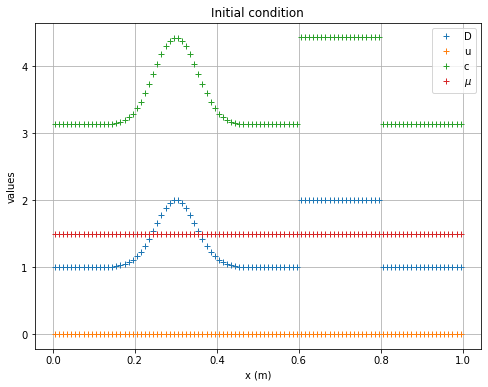

In [161]:
plt.plot(x, D, '+', label = 'D')
plt.plot(x, u, '+', label = 'u')
plt.plot(x, c, '+', label = 'c')
plt.plot(x, nu, '+', label = '$\mu$')
plt.grid()
plt.xlabel('x (m)')
plt.ylabel('values')
plt.legend()
plt.title('Initial condition')
plt.show()

### Construct the "advection" matrix

In [188]:
A = np.array([[u_0, D_0], [g, u_0 - nu_0]])
A

array([[ 0. ,  1. ],
       [ 9.8, -1.5]])

### Finding eigenvalues and eigenvectors

In [189]:
w, v = np.linalg.eig(A)
w

array([ 2.46908372, -3.96908372])

In [190]:
v

array([[ 0.37538917, -0.24431245],
       [ 0.92686729,  0.96969656]])

### Construct new variables for simple advection problem

In [191]:
q = np.array([D - D_0, u - u_0])
q

array([[1.93571479e-08, 6.32272403e-08, 1.98262591e-07, 5.96830518e-07,
        1.72478498e-06, 4.78511739e-06, 1.27445330e-05, 3.25858422e-05,
        7.99848377e-05, 1.88477747e-04, 4.26369558e-04, 9.25946706e-04,
        1.93045414e-03, 3.86372920e-03, 7.42382226e-03, 1.36937422e-02,
        2.42488095e-02, 4.12223164e-02, 6.72741248e-02, 1.05399225e-01,
        1.58525988e-01, 2.28895481e-01, 3.17283627e-01, 4.22213192e-01,
        5.39373532e-01, 6.61486763e-01, 7.78800783e-01, 8.80248504e-01,
        9.55119928e-01, 9.94910952e-01, 9.94910952e-01, 9.55119928e-01,
        8.80248504e-01, 7.78800783e-01, 6.61486763e-01, 5.39373532e-01,
        4.22213192e-01, 3.17283627e-01, 2.28895481e-01, 1.58525988e-01,
        1.05399225e-01, 6.72741248e-02, 4.12223164e-02, 2.42488095e-02,
        1.36937422e-02, 7.42382226e-03, 3.86372920e-03, 1.93045414e-03,
        9.25946706e-04, 4.26369558e-04, 1.88477747e-04, 7.99848377e-05,
        3.25858422e-05, 1.27445330e-05, 4.78511739e-06, 1.724784

In [192]:
psi = np.linalg.solve(v, q)
psi

array([[ 3.17897872e-08,  1.03836605e-07,  3.25601974e-07,
         9.80160677e-07,  2.83257368e-06,  7.85848538e-06,
         2.09300458e-05,  5.35149597e-05,  1.31357212e-04,
         3.09532556e-04,  7.00216664e-04,  1.52066043e-03,
         3.17033928e-03,  6.34531129e-03,  1.21919681e-02,
         2.24889096e-02,  3.98232477e-02,  6.76984375e-02,
         1.10482708e-01,  1.73094660e-01,  2.60343490e-01,
         3.75909647e-01,  5.21067414e-01,  6.93390763e-01,
         8.85800425e-01,  1.08634410e+00,  1.27900615e+00,
         1.44561135e+00,  1.56857092e+00,  1.63391878e+00,
         1.63391878e+00,  1.56857092e+00,  1.44561135e+00,
         1.27900615e+00,  1.08634410e+00,  8.85800425e-01,
         6.93390763e-01,  5.21067414e-01,  3.75909647e-01,
         2.60343490e-01,  1.73094660e-01,  1.10482708e-01,
         6.76984375e-02,  3.98232477e-02,  2.24889096e-02,
         1.21919681e-02,  6.34531129e-03,  3.17033928e-03,
         1.52066043e-03,  7.00216664e-04,  3.09532556e-0

### Advection

In [193]:
psi_1 = psi[0,:]
psi_2 = psi[1,:]
c_1 = w[0]
c_2 = w[1]

In [198]:
CFL = 0.1
N_cycles = 1
dx = 1/N
dt = abs(CFL * dx / c_1)
N_steps = int(1 / abs(c_1) / dt * N_cycles)

psi_1_next = advect(x, psi_1, c_1, dt, N_steps, ICA5, RK3)

In [199]:
CFL = 0.1
N_cycles = 1
dx = 1/N
dt = abs(CFL * dx / c_2)
N_steps = int(1 / abs(c_2) / dt * N_cycles)

psi_2_next = advect(x, psi_2, c_2, dt, N_steps, ICA5, RK3)

### Convert back to physical values

In [200]:
psi_next = np.array([psi_1_next, psi_2_next])
q_next = np.matmul(v, psi_next) + np.array([[D_0], [u_0]])

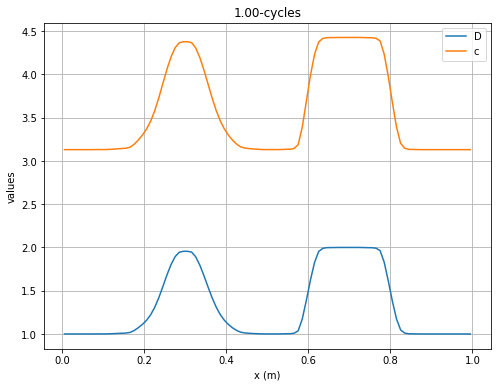

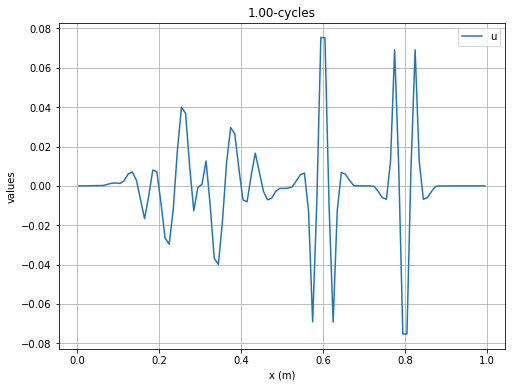

In [201]:
plt.plot(x, q_next[0,:], label = 'D')
plt.plot(x, np.sqrt(q_next[0,:] * g), label = 'c')
plt.grid()
plt.xlabel('x (m)')
plt.ylabel('values')
plt.legend()
plt.title('%.2f-cycles' % N_cycles)
plt.show()

plt.plot(x, q_next[1,:], label = 'u')
plt.grid()
plt.xlabel('x (m)')
plt.ylabel('values')
plt.legend()
plt.title('%.2f-cycles' % N_cycles)
plt.show()

In [177]:
2 * 1j

2j

In [17]:
aa = np.zeros((5,2,2))
aa

array([[[0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.]]])

In [18]:
aa[1]

array([[0., 0.],
       [0., 0.]])

## Attempt to advect using time and space dependent eigenvalues and eigenvectors

In [66]:
g = 1
D_0 = 1
u_0 = 0
N = 200
x, eta = init_smooth(N)
h = np.ones(np.size(x)) * D_0
D = h + eta
u = np.ones(np.size(x)) * u_0
c = np.sqrt(g * D)

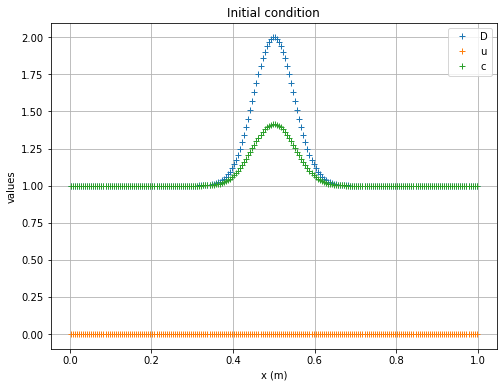

In [67]:
plt.plot(x, D, '+', label = 'D')
plt.plot(x, u, '+', label = 'u')
plt.plot(x, c, '+', label = 'c')
plt.grid()
plt.xlabel('x (m)')
plt.ylabel('values')
plt.legend()
plt.title('Initial condition')
plt.show()

In [17]:
q = np.array([D, D*u])

In [18]:
V = np.zeros((2, 2, np.size(u)))
Psi = np.zeros((2, np.size(u)))
W = np.zeros((2, np.size(u)))
for ii in np.arange(np.size(u)):
    V[:,:,ii] = np.array([[1, 1], \
                          [u[ii]-np.sqrt(g*D[ii]), u[ii]+np.sqrt(g*D[ii])]])
    W[:,ii] = np.array([u[ii]-np.sqrt(g*D[ii]), u[ii]+np.sqrt(g*D[ii])])
    #Psi[:,ii] = np.linalg.solve(V[:,:,ii], q[:,ii])
Psi = np.array([D/2, D/2])

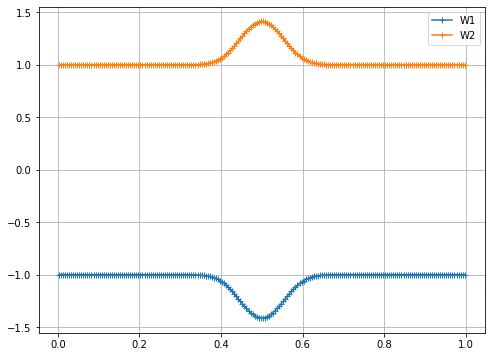

In [19]:
plt.plot(x, W[0,:], '+-', label='W1')
plt.plot(x, W[1,:], '+-', label='W2')
plt.grid()
plt.legend()

In [20]:
psi_1 = Psi[0,:]
psi_2 = Psi[1,:]
c_1 = W[0,:]
c_2 = W[1,:]

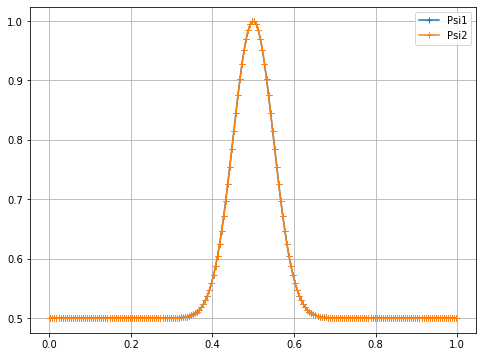

In [21]:
plt.plot(x, Psi[0,:], '+-', label='Psi1')
plt.plot(x, Psi[1,:], '+-', label='Psi2')
plt.grid()
plt.legend()

In [29]:
CFL = 0.1
N_cycles = 1
dx = 1/N
#dt = CFL * dx / np.sqrt(g*D_0*1.21) #np.amax(np.abs(W))
N_steps = 20

for kk in range(N_steps):
    dt = CFL * dx / np.amax(np.abs(u) + np.sqrt(g * D))
    #print('dt = %f\n' % dt)
    psi_1_next = advect(x, psi_1, c_1, dt, 1, ICA5, RK3)
    psi_2_next = advect(x, psi_2, c_2, dt, 1, ICA5, RK3)
    
    Psi_next = np.array([psi_1_next, psi_2_next])
    q_next = np.zeros(np.shape(q))
    for ii in np.arange(np.size(u)):
        q_next[:,ii] = np.matmul(V[:,:,ii], Psi_next[:,ii])
    
    # next step
    u = q_next[1,:] / q_next[0,:]
    D = q_next[0,:]
    q = np.array([D, D*u])
    for ii in np.arange(np.size(u)):
        V[:,:,ii] = np.array([[1, 1], \
                              [u[ii]-np.sqrt(g*D[ii]), u[ii]+np.sqrt(g*D[ii])]])
        W[:,ii] = np.array([u[ii]-np.sqrt(g*D[ii]), u[ii]+np.sqrt(g*D[ii])])
        #Psi[:,ii] = np.linalg.solve(V[:,:,ii], q[:,ii])
    Psi = np.array([D/2, D/2])    
    psi_1 = Psi[0,:]
    psi_2 = Psi[1,:]
    c_1 = W[0,:]
    c_2 = W[1,:]

In [30]:
np.shape(q_next)

(2, 200)

In [31]:
np.shape(q_next[1,:] / q_next[0,:])

(200,)

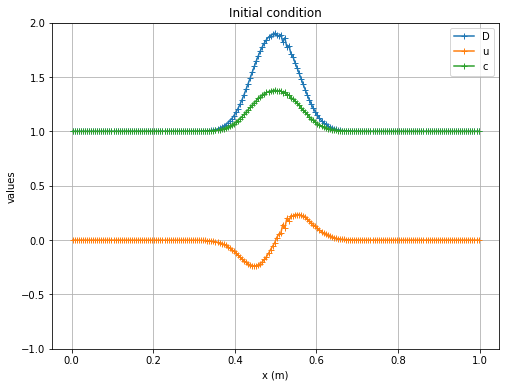

In [32]:
plt.plot(x, D, '+-', label = 'D')
plt.plot(x, u, '+-', label = 'u')
plt.plot(x, np.sqrt(g*D), '+-', label = 'c')
plt.grid()
plt.xlabel('x (m)')
plt.ylabel('values')
plt.legend()
plt.title('Initial condition')
plt.ylim((-1,2))
plt.show()

In [26]:
V[:,:,0]

array([[ 1.,  1.],
       [-1.,  1.]])

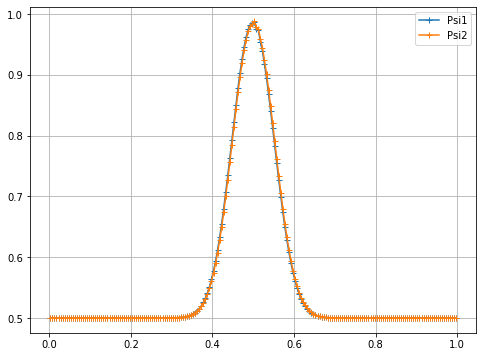

In [27]:
plt.plot(x, psi_1_next, '+-', label='Psi1')
plt.plot(x, psi_2_next, '+-', label='Psi2')
plt.grid()
plt.legend()

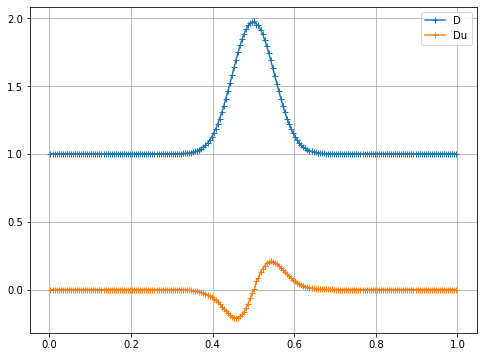

In [28]:
plt.plot(x, q_next[0,:], '+-', label='D')
plt.plot(x, q_next[1,:], '+-', label='Du')
plt.grid()
plt.legend()

In [168]:
np.amax(np.abs(W))

10.475321612304603

In [169]:
ff = np.array([2,3,5,8,13,21,24,55,89])
ff

array([ 2,  3,  5,  8, 13, 21, 24, 55, 89])

In [170]:
ff[1:5:2]

array([3, 8])

In [171]:
c_2

array([ 9.89949491,  9.89949486,  9.8994947 ,  9.89949427,  9.8994931 ,
        9.89949013,  9.89948289,  9.89946611,  9.899429  ,  9.89935095,
        9.89919498,  9.89889931,  9.89836902,  9.89747222,  9.89604938,
        9.89394803,  9.89109639,  9.88762557,  9.88403608,  9.88138118,
        9.88140956,  9.88658528,  9.89989965,  9.92442394,  9.96262872,
       10.01561659, 10.08214249, 10.15740613, 10.24267735, 10.32171109,
       10.36842218, 10.43839018, 10.45312285, 10.45031752, 10.4195719 ,
       10.36961704, 10.3055682 , 10.23501935, 10.16484099, 10.10048649,
       10.04541473, 10.00109519,  9.96737835,  9.94303918,  9.92632197,
        9.9153744 ,  9.90852815,  9.90443457,  9.902092  ,  9.90080799,
        9.90013344,  9.89979361,  9.89962934,  9.89955313,  9.89951919,
        9.89950466,  9.89949869,  9.89949633,  9.89949543,  9.89949511,
        9.89949499,  9.89949495,  9.89949494,  9.89949494,  9.89949494,
        9.89949494,  9.89949494,  9.89949494,  9.89949494,  9.89

In [38]:
dt * 2800 * np.sqrt(g*D_0)

0.28

In [254]:
# compute q = [D, Du]

# 1 cycle
# compute right-eigenvectors (R) and eigenvalues (w)
# compute Psi = R \ q
# advect Psi_i using v_i for all i
# compute q = R * Psi

In [255]:
# what about applying local R_j on q_{j+k} to compute Psi_{j+1/2} 

In [54]:
# find Psi_{j+1/2}
def non_linear_flux_method(q, W, V, u, D):
    f = np.zeros(np.shape(q))
    for ii in range(np.size(D)):
        alpha = 4

        psi_0 = np.linalg.solve(V[:,:,ii], q[:,ii])
        psi_1L = np.linalg.solve(V[:,:,ii], np.roll(q,1,axis=1)[:,ii])
        psi_2L = np.linalg.solve(V[:,:,ii], np.roll(q,2,axis=1)[:,ii])
        psi_1R = np.linalg.solve(V[:,:,ii], np.roll(q,-1,axis=1)[:,ii])
        psi_2R = np.linalg.solve(V[:,:,ii], np.roll(q,-2,axis=1)[:,ii])

        psi_half = 7/12 * (psi_0 + psi_1R) - 1/12 * (psi_1L + psi_2R)

        psi_MPL = psi_0 + minmod(psi_1R - psi_0, alpha * (psi_0 - psi_1L))
        psi_L = median(psi_half, psi_0, psi_MPL)

        psi_MPR = psi_1R + minmod(psi_0 - psi_1R, alpha * (psi_1R - psi_2R))
        psi_R = median(psi_half, psi_1R, psi_MPR)

        # find c_max
        c_abs = np.abs(u) + np.sqrt(g * D)
        c_max = maxmax(np.roll(c_abs, 1), c_abs, np.roll(c_abs, -1)) * 1.1
        f[:,ii] = W[:,ii]/2 * (psi_L + psi_R) - np.abs(W[:,ii])/2 * (psi_R - psi_L)
    return f

In [55]:
g = 1
D_0 = 1
u_0 = 0
N = 200
x, eta = init_smooth(N)
h = np.ones(np.size(x)) * D_0
D = h + eta
u = np.ones(np.size(x)) * u_0
c = np.sqrt(g * D)

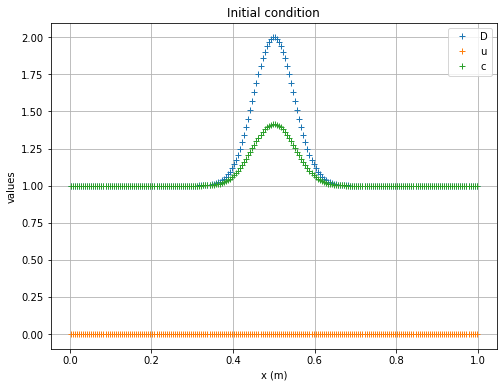

In [56]:
plt.plot(x, D, '+', label = 'D')
plt.plot(x, u, '+', label = 'u')
plt.plot(x, c, '+', label = 'c')
plt.grid()
plt.xlabel('x (m)')
plt.ylabel('values')
plt.legend()
plt.title('Initial condition')
plt.show()

In [57]:
q = np.array([D, D*u])

In [58]:
V = np.zeros((2, 2, np.size(u)))
Psi = np.zeros((2, np.size(u)))
W = np.zeros((2, np.size(u)))
for ii in np.arange(np.size(u)):
    V[:,:,ii] = np.array([[1, 1], \
                          [u[ii]-np.sqrt(g*D[ii]), u[ii]+np.sqrt(g*D[ii])]])
    W[:,ii] = np.array([u[ii]-np.sqrt(g*D[ii]), u[ii]+np.sqrt(g*D[ii])])
    #Psi[:,ii] = np.linalg.solve(V[:,:,ii], q[:,ii])
Psi = np.array([D/2, D/2])

In [59]:
# advect
def non_linear_advect_RK3(Psi, W, V, u, D, dt, dx):
    w0 = Psi
    f0 = non_linear_flux_method(q, W, V, u, D)
    w1 = w0 + (dt/dx) * (-f0 + np.roll(f0, 1))

    q1 = np.zeros(np.shape(q))
    for ii in np.arange(np.size(u)):
        q1[:,ii] = np.matmul(V[:,:,ii], w1[:,ii])
    u1 = q1[1,:] / q1[0,:]
    D1 = q1[0,:]

    V1 = np.zeros(np.shape(V))
    W1 = np.zeros(np.shape(W))
    for ii in np.arange(np.size(u)):
        V1[:,:,ii] = np.array([[1, 1], \
                              [u1[ii]-np.sqrt(g*D1[ii]), u1[ii]+np.sqrt(g*D1[ii])]])
        W1[:,ii] = np.array([u1[ii]-np.sqrt(g*D1[ii]), u1[ii]+np.sqrt(g*D1[ii])])
    Psi1 = np.array([D1/2, D1/2])
    
    f1 = non_linear_flux_method(q1, W1, V1, u1, D1)
    w2 = 3/4 * w0 + 1/4 * (w1 + (dt/dx) * (-f1 + np.roll(f1, 1)))
    
    q2 = np.zeros(np.shape(q))
    for ii in np.arange(np.size(u)):
        q2[:,ii] = np.matmul(V1[:,:,ii], w2[:,ii])
    u2 = q2[1,:] / q2[0,:]
    D2 = q2[0,:]

    V2 = np.zeros(np.shape(V))
    W2 = np.zeros(np.shape(W))
    for ii in np.arange(np.size(u)):
        V2[:,:,ii] = np.array([[1, 1], \
                              [u2[ii]-np.sqrt(g*D2[ii]), u2[ii]+np.sqrt(g*D2[ii])]])
        W2[:,ii] = np.array([u2[ii]-np.sqrt(g*D2[ii]), u2[ii]+np.sqrt(g*D2[ii])])
    Psi2 = np.array([D2/2, D2/2])
    
    f2 = non_linear_flux_method(q2, W2, V2, u1, D1)
    
    w3 = 1/3 * w0 + 2/3 * (w2 + (dt/dx) * (-f2 + np.roll(f2, 1)))
    
    Psi_next = w3
    return Psi_next, W2, V2

In [62]:
CFL = 0.05
dx = 1/N
#dt = CFL * dx / np.sqrt(g*D_0*1.21) #np.amax(np.abs(W))
N_steps = 100

for ii in range(N_steps):
    dt = CFL * dx / np.amax(np.abs(u) + np.sqrt(g * D))

    Psi2, W2, V2 = non_linear_advect_RK3(Psi, W, V, u, D, dt, dx)
    q2 = np.zeros(np.shape(q))
    for ii in np.arange(np.size(u)):
        q2[:,ii] = np.matmul(V2[:,:,ii], Psi2[:,ii])
    u2 = q2[1,:] / q2[0,:]
    D2 = q2[0,:]

    dD = D2 - D
    du = u2 - u
    #plt.plot(x, dD, label = 'dD')
    #plt.plot(x, du, label = 'du')
    #plt.legend()
    #plt.grid()
    #plt.title('dt = %.7f' % dt)
    #plt.show()
    
    D = D2
    u = u2


    
    for ii in np.arange(np.size(u)):
        V[:,:,ii] = np.array([[1, 1], \
                              [u[ii]-np.sqrt(g*D[ii]), u[ii]+np.sqrt(g*D[ii])]])
        W[:,ii] = np.array([u[ii]-np.sqrt(g*D[ii]), u[ii]+np.sqrt(g*D[ii])])
    Psi = np.array([D/2, D/2])

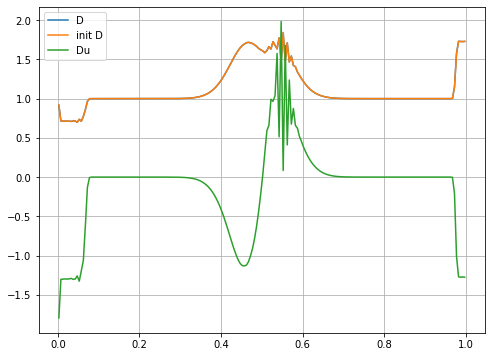

In [63]:
plt.plot(x,D2,label='D')
plt.plot(x,D,label='init D')
plt.plot(x,q2[1,:],label='Du')
plt.grid()
plt.legend()
plt.show()